In [1]:
import torch
import numpy as np
from functools import partial

In [2]:
import sys
#sys.path.append('./NVIDIA_physicsnemo_examples-weather_corrdiff_DB/datasets')
sys.path.append('/leap/DB_scratch/physicsnemo/research/corrdiff_27_Nov')

In [ ]:
from datasets.nyc import NYCwindowDataset

In [5]:
dataset = NYCwindowDataset(
    data_path='',
    stats_path='',
    preload=True,
    sel_time=[0, 10]  # Just 10 samples for demo
)

Preloading data into memory...
Loaded input: (10, 65, 128, 128), output: (10, 20, 128, 128)


In [6]:
print(f"Dataset size: {len(dataset)}")
print(f"Image shape: {dataset.image_shape()}")
print(f"Input channels: {len(dataset.input_channels())}")
print(f"Output channels: {len(dataset.output_channels())}")


Dataset size: 10
Image shape: (128, 128)
Input channels: 65
Output channels: 20


In [15]:
# ==============================================================================
# STEP 2: Get a single sample
# ==============================================================================
image_tar, image_lr = dataset[0]
image_tar_t = torch.from_numpy(image_tar)
image_lr_t = torch.from_numpy(image_lr)
print(f"\nSample shapes:")
print(f"  Target (HR): {image_tar_t.shape}")
print(f"  Input (LR): {image_lr_t.shape}")


Sample shapes:
  Target (HR): torch.Size([20, 128, 128])
  Input (LR): torch.Size([65, 128, 128])


In [29]:
dataset.output_channels()

[ChannelMetadata(name='refc|t-2', level='', auxiliary=False),
 ChannelMetadata(name='refc|t-1', level='', auxiliary=False),
 ChannelMetadata(name='refc|t+0', level='', auxiliary=False),
 ChannelMetadata(name='refc|t+1', level='', auxiliary=False),
 ChannelMetadata(name='refc|t+2', level='', auxiliary=False),
 ChannelMetadata(name='t2m|t-2', level='', auxiliary=False),
 ChannelMetadata(name='t2m|t-1', level='', auxiliary=False),
 ChannelMetadata(name='t2m|t+0', level='', auxiliary=False),
 ChannelMetadata(name='t2m|t+1', level='', auxiliary=False),
 ChannelMetadata(name='t2m|t+2', level='', auxiliary=False),
 ChannelMetadata(name='u10|t-2', level='', auxiliary=False),
 ChannelMetadata(name='u10|t-1', level='', auxiliary=False),
 ChannelMetadata(name='u10|t+0', level='', auxiliary=False),
 ChannelMetadata(name='u10|t+1', level='', auxiliary=False),
 ChannelMetadata(name='u10|t+2', level='', auxiliary=False),
 ChannelMetadata(name='v10|t-2', level='', auxiliary=False),
 ChannelMetadata(na

In [ ]:
# ==============================================================================
# STEP 3: Load Models
# ==============================================================================
from physicsnemo import Module

# Load regression model (deterministic baseline)
net_reg = Module.from_checkpoint("/leap/DB_scratch/physicsnemo/research/corrdiff_27_Nov/results_nyc_window_2/checkpoints/checkpoints_regression/UNet.0.10000384.mdlus")
net_reg = net_reg.eval().cuda().to(memory_format=torch.channels_last)

# Load diffusion residual model (stochastic refinement)
net_res = Module.from_checkpoint('/leap/DB_scratch/physicsnemo/research/corrdiff_27_Nov/results_nyc_window_2/checkpoints/checkpoints_diffusion/EDMPrecondSuperResolution.0.10000384.mdlus')
net_res = net_res.eval().cuda().to(memory_format=torch.channels_last)


In [17]:
# ==============================================================================
# STEP 4: Regression Step (Deterministic Prediction)
# ==============================================================================
from physicsnemo.utils.corrdiff import regression_step

img_lr_batch = image_lr_t.unsqueeze(0).cuda()  # Add batch dim
print(f"\nInput for regression: {img_lr_batch.shape}")



Input for regression: torch.Size([1, 65, 128, 128])


In [18]:
image_reg = regression_step(
    net=net_reg,
    img_lr=img_lr_batch,
    latents_shape=(1, len(dataset.output_channels()), 128, 128),
    lead_time_label=None
)
print(f"Regression output: {image_reg.shape}")


Regression output: torch.Size([1, 20, 128, 128])


In [20]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Regression pred')

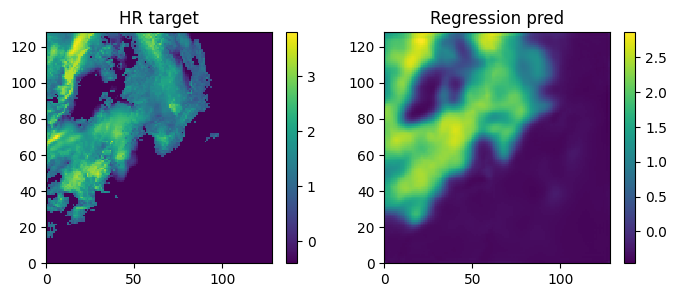

In [25]:
plt.figure(figsize=(8,3))

plt.subplot(121)
plt.pcolormesh(image_tar[0,:,:])
plt.colorbar()
plt.title("HR target")


plt.subplot(122)
plt.pcolormesh(image_reg[0,0,:,:].cpu().numpy())
plt.colorbar()
plt.title('Regression pred')

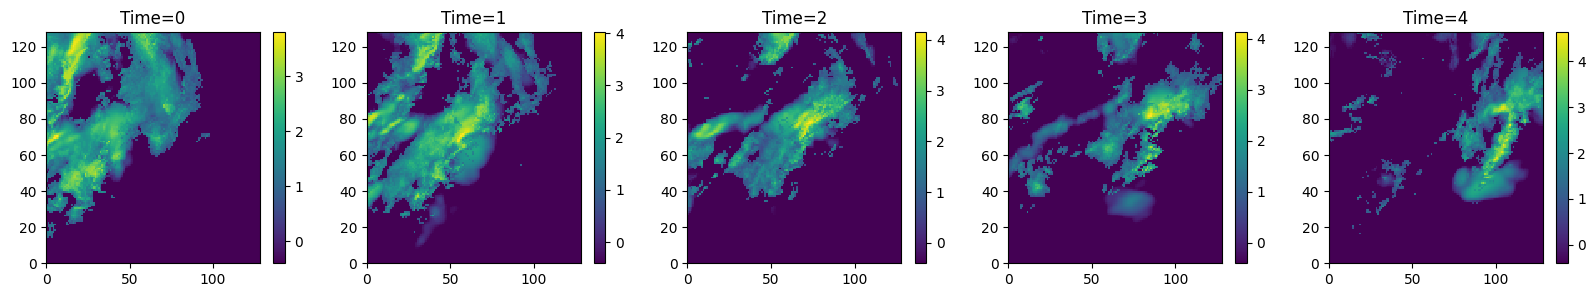

In [35]:
plt.figure(figsize=(20,3))

var_num = 0

for i in range(5):
    plt.subplot(151+i)
    plt.pcolormesh(image_tar[i + var_num*5,:,:])
    plt.colorbar()
    plt.title("Time="+str(i))


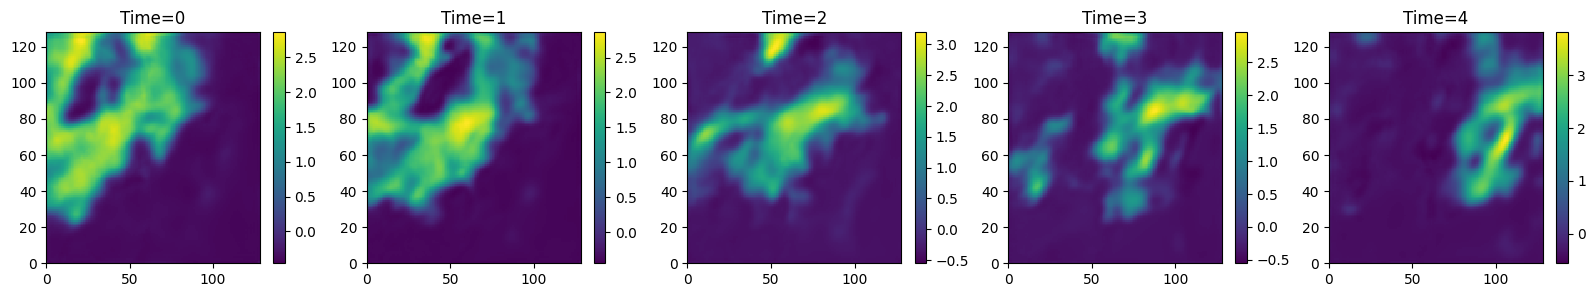

In [36]:
plt.figure(figsize=(20,3))

for i in range(5):
    plt.subplot(151+i)
    plt.pcolormesh(image_reg[0,i + var_num*5 ,:,:].cpu().numpy())
    plt.colorbar()
    plt.title("Time="+str(i))


In [56]:
# ==============================================================================
# STEP 5: Diffusion Step (Stochastic Refinement)
# ==============================================================================
from physicsnemo.utils.corrdiff import diffusion_step
from physicsnemo.utils.diffusion import deterministic_sampler, stochastic_sampler

# Match generate.py exactly
# from omegaconf import OmegaConf
# cfg = OmegaConf.load('/leap/DB_scratch/physicsnemo/research/corrdiff_27_Nov/conf/config_generate_nyc_2.yaml')

# sampler_fn = partial(
#     deterministic_sampler,
#     num_steps=cfg.sampler.num_steps,
#     solver=cfg.sampler.solver,
#     patching=None
# )


In [59]:

# un comment below for simple deterministic sampler
# Create sampler function
# sampler_fn = partial(
#     deterministic_sampler,
#     num_steps=35,
#     solver='heun',
#     patching=None
# )
sampler_fn = partial(stochastic_sampler, patching=None)


# Generate ensemble of 4 members
num_ensembles = 4
seeds = list(range(num_ensembles))

image_res = diffusion_step(
    net=net_res,
    sampler_fn=sampler_fn,
    img_shape=(128, 128),
    img_out_channels=len(dataset.output_channels()),
    rank_batches=[seeds],  # All seeds in one batch
    img_lr=img_lr_batch.expand(num_ensembles, -1, -1, -1),
    rank=0,
    device='cuda',
    mean_hr=image_reg[0:1],  # Use regression as mean
    lead_time_label=None
)
print(f"\nDiffusion output (ensemble): {image_res.shape}")


  0%|                                                                                                                                                                                               | 0/1 [00:00<?, ?batch/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07batch/s]


Diffusion output (ensemble): torch.Size([4, 20, 128, 128])


In [60]:
# ==============================================================================
# STEP 6: Combine Predictions
# ==============================================================================
# Option 1: Regression only
output_regression = image_reg

# Option 2: Diffusion only
output_diffusion = image_res

# Option 3: Combined (regression + diffusion residual)
output_combined = image_reg + image_res

print(f"\nFinal outputs:")
print(f"  Regression: {output_regression.shape}")
print(f"  Diffusion: {output_diffusion.shape}")
print(f"  Combined: {output_combined.shape}")


Final outputs:
  Regression: torch.Size([1, 20, 128, 128])
  Diffusion: torch.Size([4, 20, 128, 128])
  Combined: torch.Size([4, 20, 128, 128])


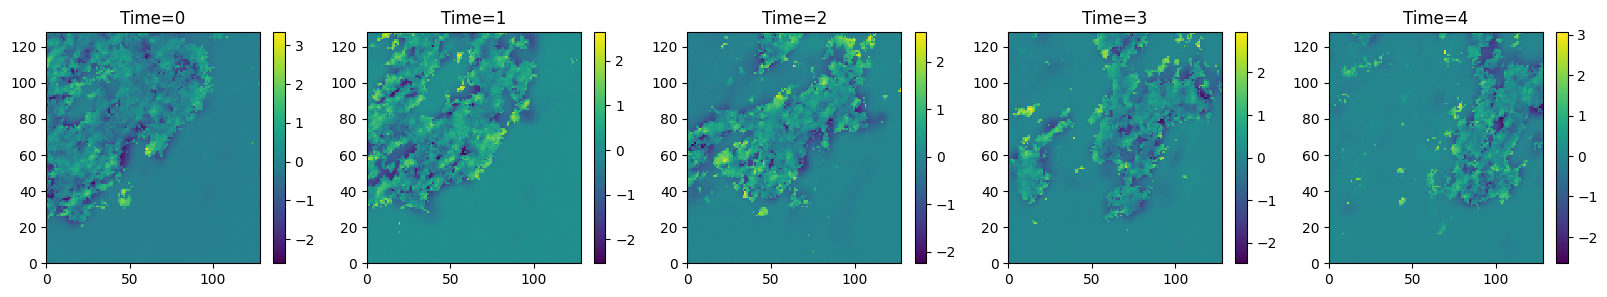

In [61]:
plt.figure(figsize=(20,3))

for i in range(5):
    plt.subplot(151+i)
    plt.pcolormesh(output_diffusion[0,i + var_num*5 ,:,:].cpu().numpy())
    plt.colorbar()
    plt.title("Time="+str(i))


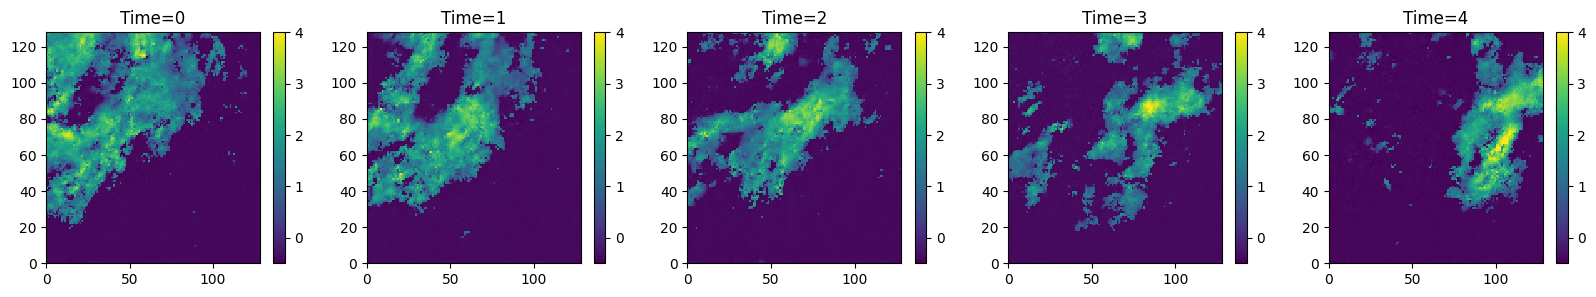

In [62]:
plt.figure(figsize=(20,3))
vmin = -0.5
vmax = 4
for i in range(5):
    plt.subplot(151+i)
    plt.pcolormesh( output_combined[1,i + var_num*5 ,:,:].cpu().numpy(), vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.title("Time="+str(i))


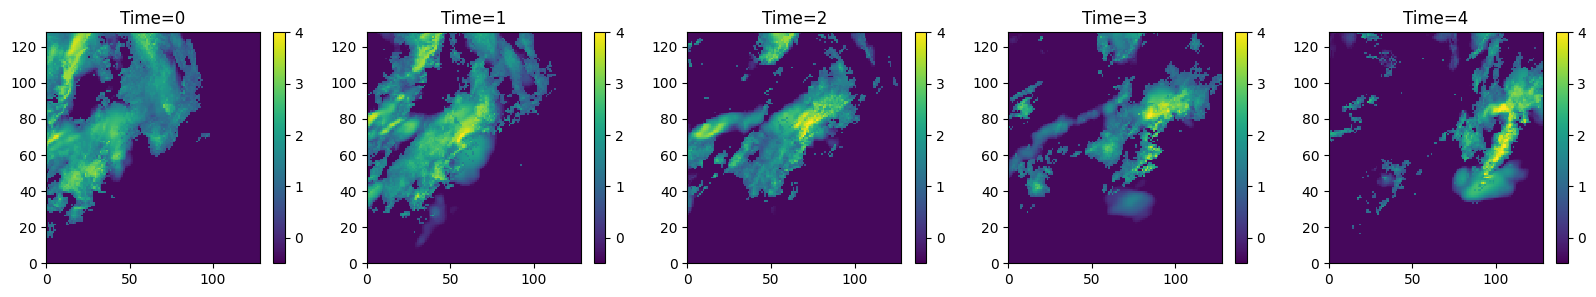

In [63]:
plt.figure(figsize=(20,3))

var_num = 0

for i in range(5):
    plt.subplot(151+i)
    plt.pcolormesh(image_tar[i + var_num*5,:,:], vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.title("Time="+str(i))


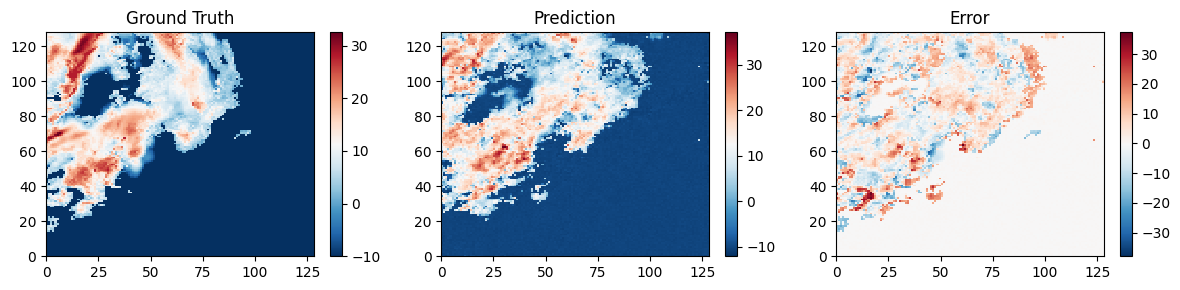

In [64]:
# ==============================================================================
# STEP 7: Denormalize and Visualize
# ==============================================================================
import matplotlib.pyplot as plt

# Denormalize (convert back to physical units)
output_phys = dataset.denormalize_output(output_combined[0].cpu().numpy())
target_phys = dataset.denormalize_output(image_tar_t.cpu().numpy())

# Plot first channel (e.g., temperature)
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

axes[0].pcolormesh(target_phys[0], cmap='RdBu_r')
fig.colorbar(axes[0].collections[0], ax=axes[0])
axes[0].set_title('Ground Truth')

axes[1].pcolormesh(output_phys[0], cmap='RdBu_r')
fig.colorbar(axes[1].collections[0], ax=axes[1])
axes[1].set_title('Prediction')

axes[2].pcolormesh(output_phys[0] - target_phys[0], cmap='RdBu_r')
fig.colorbar(axes[2].collections[0], ax=axes[2])
axes[2].set_title('Error')

plt.tight_layout()
plt.show()